# Libraries importieren

In [22]:
import json
import scipy as sp
import pandas as pd
import random
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import louvain_communities

Ideen:
Centrality Analysis:
- Degree Centrality: Identify who interacts the most; they are socially active and likely to have allies.
- Betweenness Centrality: Find characters who act as bridges; eliminating them disrupts communication.
- Closeness Centrality: Spot the actors who can quickly spread influence throughout the network.
Cluster Analysis: Identify the communities or factions. The "enemy" may lead or significantly influence one cluster.
Netzwerk vergleichen von bös zu schlecht
- Link prediction über Episoden
- Analyse über Episoden

# Daten laden

In [23]:
def get_data(path):
    file_path = path
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [24]:
interaction_data = get_data("data/starwars-full-interactions-allCharacters.json")
mention_data = get_data("data/starwars-full-mentions.json")

# Daten analysieren

In [25]:
# Anzahl der Knoten in den Interaktionsdaten
print("Anzahl der Knoten in den Interaktionsdaten: ", len(interaction_data['nodes']))
# Anzahl der Kanten in den Interaktionsdaten
print("Anzahl der Kanten in den Interaktionsdaten: ", len(interaction_data['links']))


Anzahl der Knoten in den Interaktionsdaten:  112
Anzahl der Kanten in den Interaktionsdaten:  450


In [26]:
# Anzahl der Knoten in den Erwähnungsdaten
print("Anzahl der Knoten in den Erwähnungsdaten: ", len(mention_data['nodes']))
# Anzahl der Kanten in den Erwähnungsdaten
print("Anzahl der Kanten in den Erwähnungsdaten: ", len(mention_data['links']))


Anzahl der Knoten in den Erwähnungsdaten:  113
Anzahl der Kanten in den Erwähnungsdaten:  817


In [27]:
# Knoten in den Interaktionsdaten
interaction_data['nodes']

[{'name': 'R2-D2', 'value': 171, 'colour': '#bde0f6'},
 {'name': 'CHEWBACCA', 'value': 145, 'colour': '#A0522D'},
 {'name': 'BB-8', 'value': 40, 'colour': '#eb5d00'},
 {'name': 'QUI-GON', 'value': 62, 'colour': '#4f4fb1'},
 {'name': 'NUTE GUNRAY', 'value': 25, 'colour': '#808080'},
 {'name': 'PK-4', 'value': 4, 'colour': '#808080'},
 {'name': 'TC-14', 'value': 5, 'colour': '#808080'},
 {'name': 'OBI-WAN', 'value': 148, 'colour': '#48D1CC'},
 {'name': 'DOFINE', 'value': 4, 'colour': '#808080'},
 {'name': 'RUNE', 'value': 11, 'colour': '#808080'},
 {'name': 'TEY HOW', 'value': 5, 'colour': '#808080'},
 {'name': 'EMPEROR', 'value': 52, 'colour': '#191970'},
 {'name': 'CAPTAIN PANAKA', 'value': 20, 'colour': '#808080'},
 {'name': 'SIO BIBBLE', 'value': 9, 'colour': '#808080'},
 {'name': 'JAR JAR', 'value': 42, 'colour': '#9a9a00'},
 {'name': 'TARPALS', 'value': 4, 'colour': '#808080'},
 {'name': 'BOSS NASS', 'value': 5, 'colour': '#808080'},
 {'name': 'PADME', 'value': 75, 'colour': '#DDA0

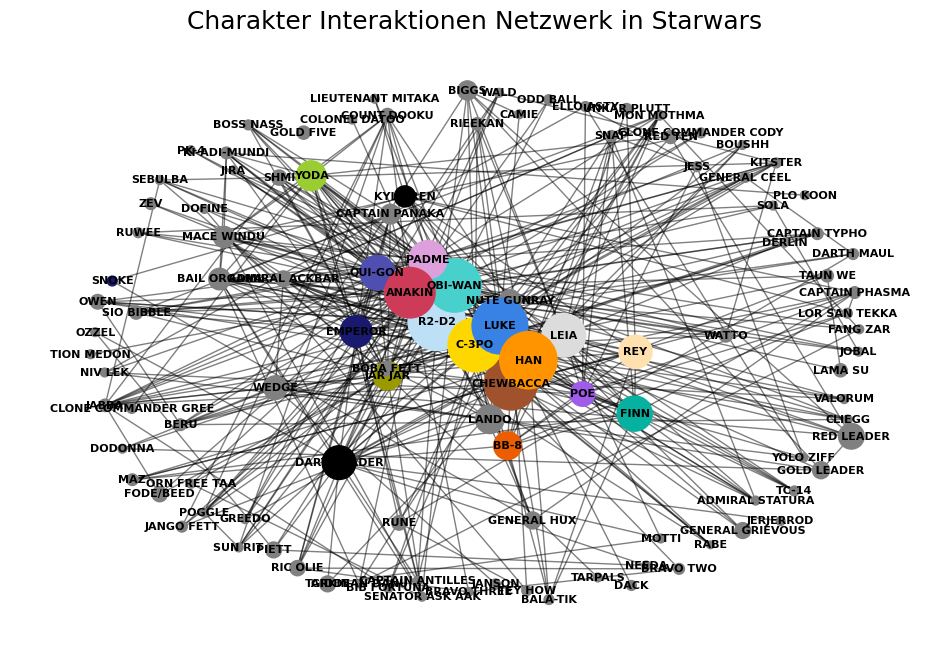

In [28]:
G = nx.Graph()

for node in interaction_data['nodes']:
    G.add_node(node['name'], value=node['value'], color=node['colour'])

for link in interaction_data['links']:
    source = interaction_data['nodes'][link['source']]['name']
    target = interaction_data['nodes'][link['target']]['name']
    G.add_edge(source, target, weight=link['value'])

pos = nx.spring_layout(G, seed=42, k=2)
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_sizes = [G.nodes[node]['value'] * 10 for node in G.nodes] #Skalierung mal 10

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_weight='bold')
plt.title("Charakter Interaktionen Netzwerk in Starwars", fontsize=18)
plt.axis('off')
plt.show()


Suchen ob es mehere Subgraphen gibt die untereinander nicht verbunden sind.

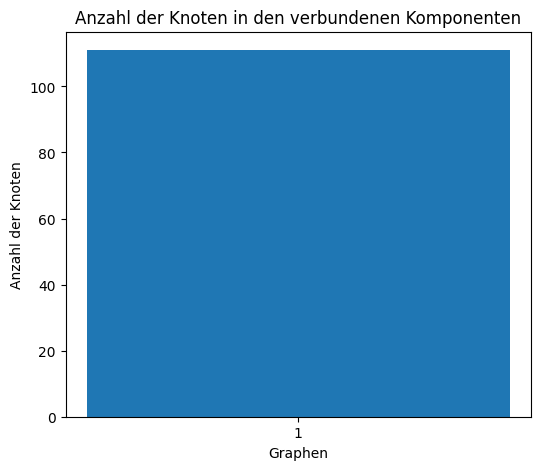

In [43]:
connected_components = list(nx.connected_components(G))
num_components = len(connected_components)
component_sizes = [len(component) for component in connected_components]

plt.figure(figsize=(6, 5))
plt.bar(range(1, num_components + 1), component_sizes)
plt.xlabel("Graphen")
plt.ylabel("Anzahl der Knoten")
plt.title("Anzahl der Knoten in den verbundenen Komponenten")
plt.xticks(range(1, num_components + 1))
plt.show()

In [30]:
#print connected components 2
num_components, component_sizes

(2, [111, 1])

Eine Node scheint keine Interaktionen zu haben. Dies könnte ein Fehler in den Daten sein.

In [31]:
connected_components[1]

{'GOLD FIVE'}

Gold five ist ein Pilot der Rebellenallianz und hat keine Interaktionen. Dies könnte ein Fehler in den Daten sein.

In [32]:
G.remove_node('GOLD FIVE')

# Analyse der Cliques

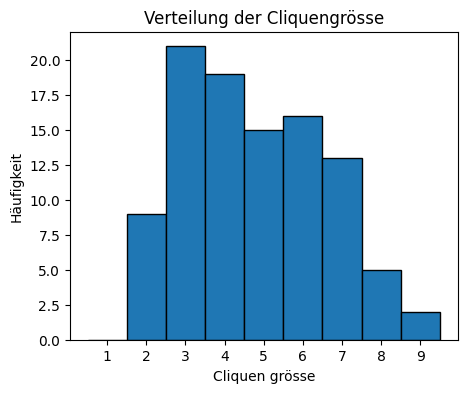

In [33]:
cliques = list(nx.find_cliques(G))
clique_sizes = [len(clique) for clique in cliques]
max_clique_size = max(clique_sizes)
num_cliques = len(cliques)

plt.figure(figsize=(5, 4))
plt.hist(clique_sizes, bins=range(1, max_clique_size + 2), edgecolor='black', align='left')
plt.xlabel("Cliquen grösse")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Cliquengrösse")
plt.xticks(range(1, max_clique_size + 1))
plt.show()

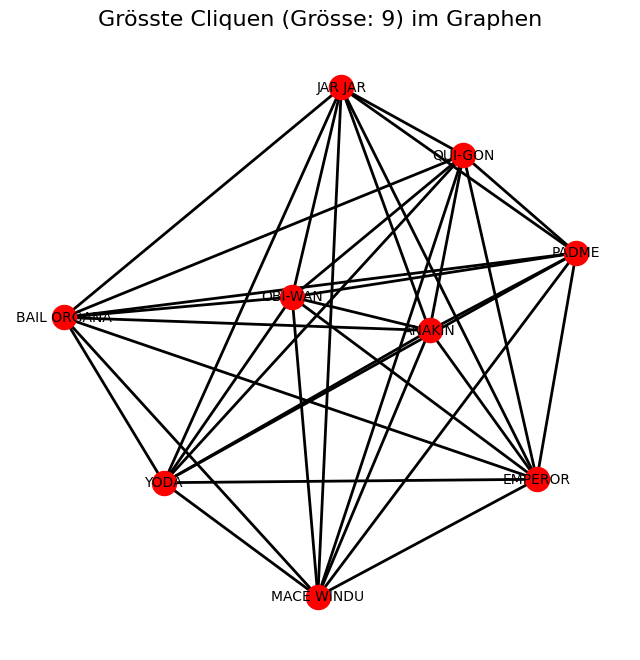

In [34]:
largest_cliques = [clique for clique in cliques if len(clique) == max_clique_size]
largest_clique = largest_cliques[0]
subgraph_clique = G.subgraph(largest_clique)
pos_clique = nx.spring_layout(subgraph_clique, seed=42)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(subgraph_clique, pos_clique, node_color='red', node_size=300)
nx.draw_networkx_edges(subgraph_clique, pos_clique, width=2)
nx.draw_networkx_labels(subgraph_clique, pos_clique, font_size=10, font_color='black')
plt.title(f"Grösste Cliquen (Grösse: {max_clique_size}) im Graphen", fontsize=16)
plt.axis('off')
plt.show()

# Analyse Edge-Betweenness Clustering

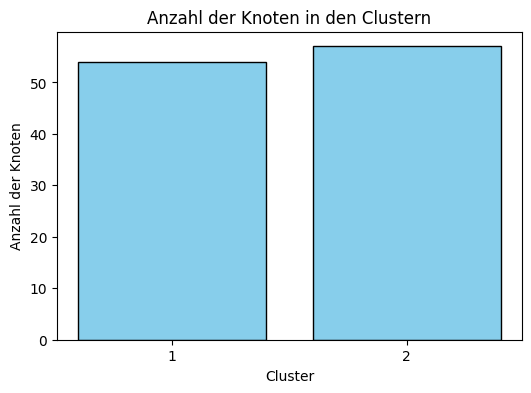

In [35]:
communities_generator = girvan_newman(G)
first_level_communities = next(communities_generator)
clusters = [list(community) for community in first_level_communities]

num_clusters = len(clusters)
cluster_sizes = [len(cluster) for cluster in clusters]

plt.figure(figsize=(6, 4))
plt.bar(range(1, num_clusters + 1), cluster_sizes, color='skyblue', edgecolor='black')
plt.xlabel("Cluster")
plt.ylabel("Anzahl der Knoten")
plt.title("Anzahl der Knoten in den Clustern")
plt.xticks(range(1, num_clusters + 1))
plt.show()

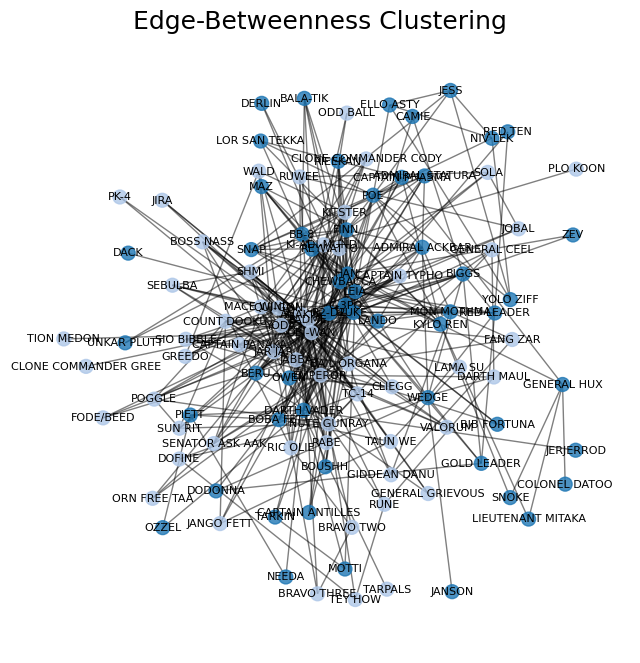

(2, [54, 57])

In [36]:
cmap = matplotlib.colormaps.get_cmap("tab20")
colors = [cmap(i) for i in range(num_clusters)]
color_map = {}

for cluster_index, cluster_nodes in enumerate(clusters):
    for node in cluster_nodes:
        color_map[node] = colors[cluster_index]

node_colors = [color_map[node] for node in G.nodes]

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42,k=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
plt.title("Edge-Betweenness Clustering", fontsize=18)
plt.axis('off')
plt.show()

num_clusters, cluster_sizes

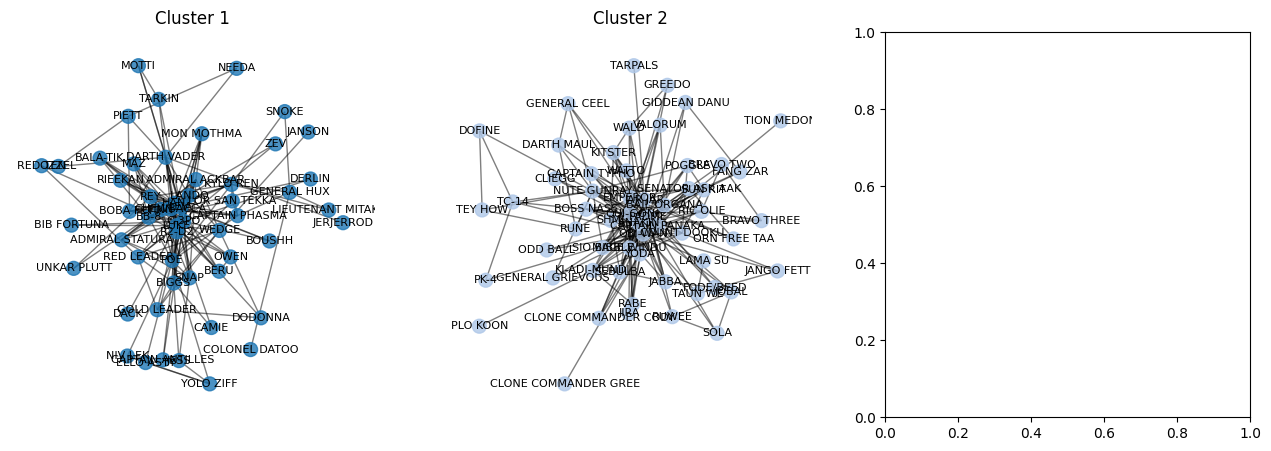

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    if i >= 1 * 3:
        break

    subgraph = G.subgraph(cluster)
    pos_subgraph = nx.spring_layout(subgraph, seed=42, k=0.8)
    ax = axes[i]
    nx.draw_networkx_nodes(subgraph, pos_subgraph, node_color=[colors[i]] * len(subgraph),
                           node_size=100, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(subgraph, pos_subgraph, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(subgraph, pos_subgraph, font_size=8, font_color='black', ax=ax)
    ax.set_title(f"Cluster {i + 1}", fontsize=12)
    ax.axis('off')


# Label Propagation Community Detection

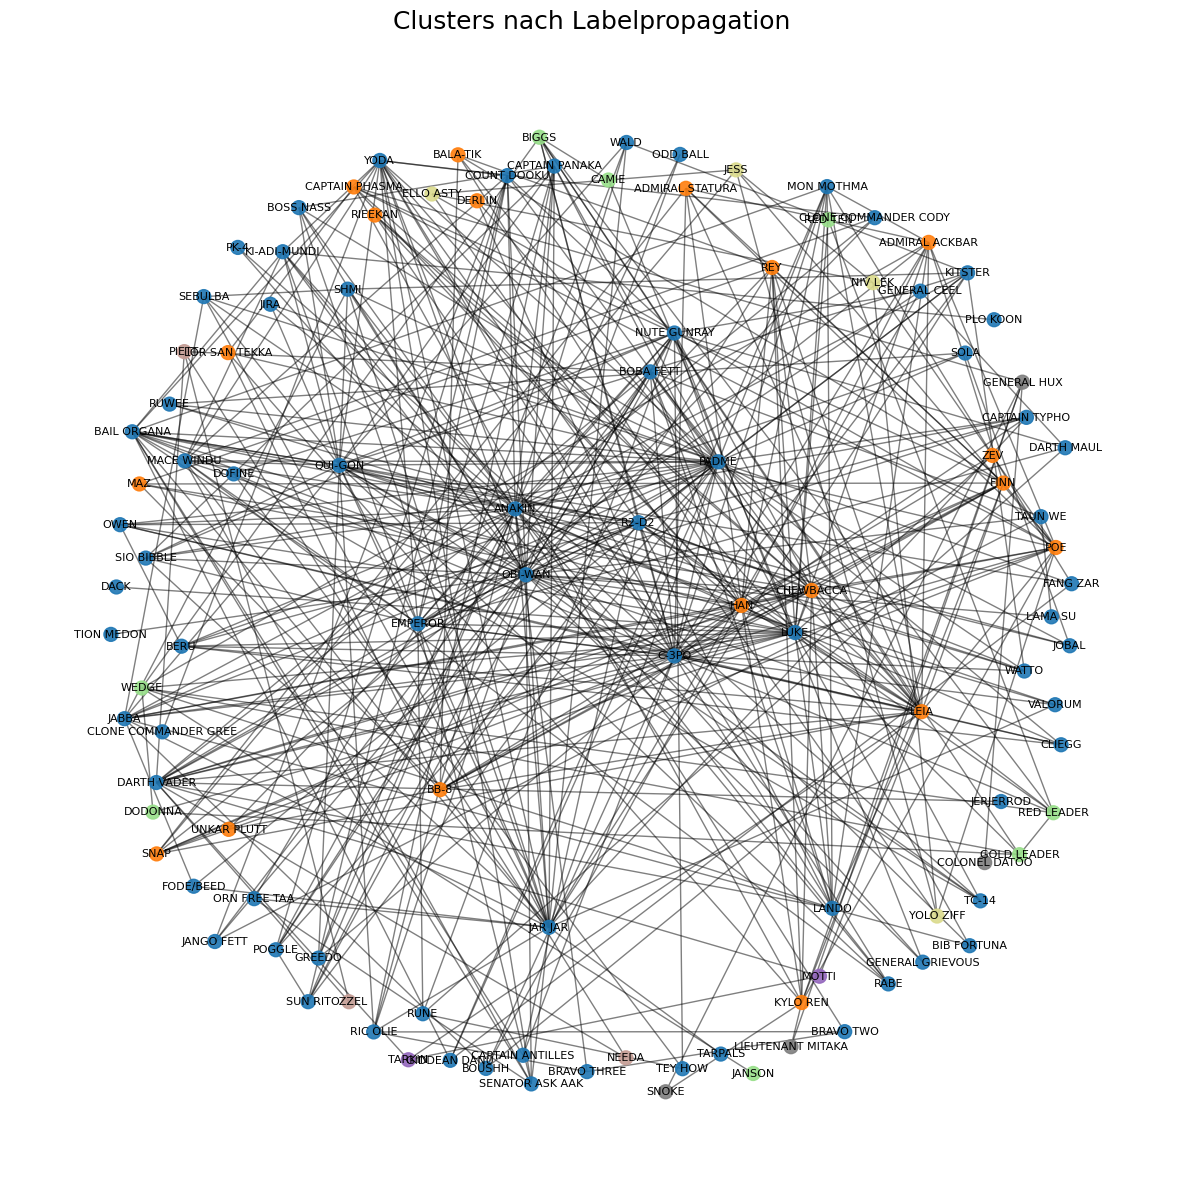

In [38]:
label_propagation_communities_result = list(nx.algorithms.community.label_propagation_communities(G))
num_label_propagation_communities = len(label_propagation_communities_result)
distinct_colors_lp = [plt.cm.tab20(i / num_label_propagation_communities) for i in range(num_label_propagation_communities)]

label_propagation_color_map = {}
for i, community in enumerate(label_propagation_communities_result):
    for node in community:
        label_propagation_color_map[node] = distinct_colors_lp[i]

node_colors_label_propagation = [label_propagation_color_map[node] for node in G.nodes]

plt.figure(figsize=(15, 15))
pos_label_propagation = nx.spring_layout(G, seed=42, k=3)
nx.draw_networkx_nodes(G, pos_label_propagation, node_color=node_colors_label_propagation, node_size=100, alpha=0.9)
nx.draw_networkx_edges(G, pos_label_propagation, alpha=0.5)
nx.draw_networkx_labels(G, pos_label_propagation, font_size=8, font_color='black')
plt.title("Clusters nach Labelpropagation", fontsize=18)
plt.axis('off')
plt.show()


In [39]:
# print the communities
len(label_propagation_communities_result)

7

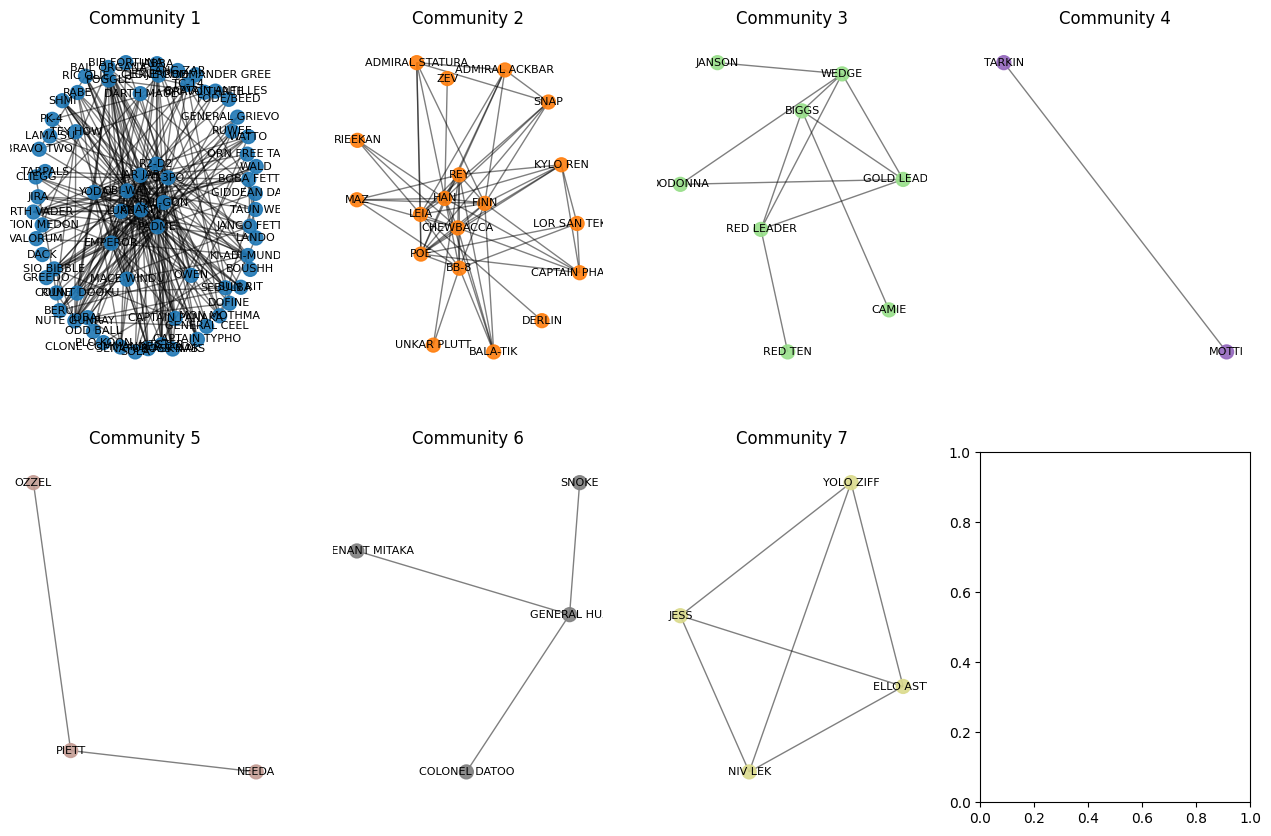

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, community in enumerate(label_propagation_communities_result):
    if i >= 2 * 4:
        break

    subgraph = G.subgraph(community)
    pos_subgraph = nx.spring_layout(subgraph, seed=42, k=3)
    ax = axes[i]
    nx.draw_networkx_nodes(subgraph, pos_subgraph, node_color=[distinct_colors_lp[i]] * len(subgraph),
                           node_size=100, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(subgraph, pos_subgraph, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(subgraph, pos_subgraph, font_size=8, font_color='black', ax=ax)
    ax.set_title(f"Community {i + 1}", fontsize=12)
    ax.axis('off')

# Louvain Community Detection

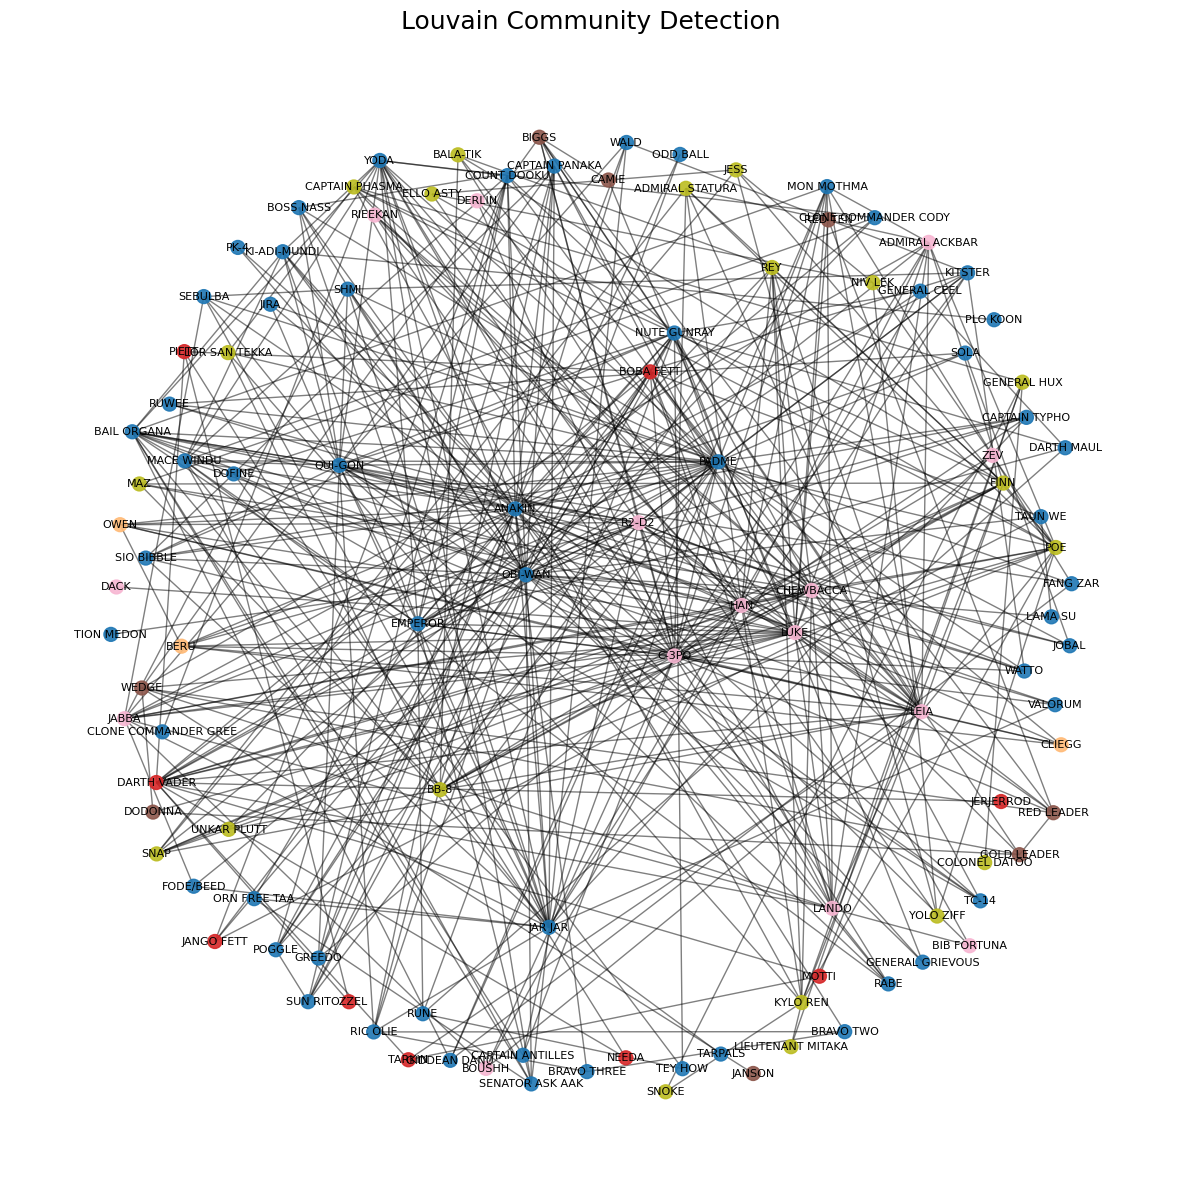

In [41]:
louvain_communities_result = louvain_communities(G, seed=42)
num_louvain_communities = len(louvain_communities_result)

louvain_colors = plt.cm.rainbow(range(num_louvain_communities))
louvain_color_map = {}

for community_index, community_nodes in enumerate(louvain_communities_result):
    for node in community_nodes:
        louvain_color_map[node] = louvain_colors[community_index % len(louvain_colors)]

node_colors_louvain = [louvain_color_map[node] for node in G.nodes]

distinct_colors = [plt.cm.tab20(i / num_louvain_communities) for i in range(num_louvain_communities)]
node_colors_louvain_distinct = []
for node in G.nodes:
    for i, community in enumerate(louvain_communities_result):
        if node in community:
            node_colors_louvain_distinct.append(distinct_colors[i])

plt.figure(figsize=(15, 15))
pos_louvain = nx.spring_layout(G, seed=42, k=3)
nx.draw_networkx_nodes(G, pos_louvain, node_color=node_colors_louvain_distinct, node_size=100, alpha=0.9)
nx.draw_networkx_edges(G, pos_louvain, alpha=0.5)
nx.draw_networkx_labels(G, pos_louvain, font_size=8, font_color='black')
plt.title("Louvain Community Detection", fontsize=18)
plt.axis('off')
plt.show()

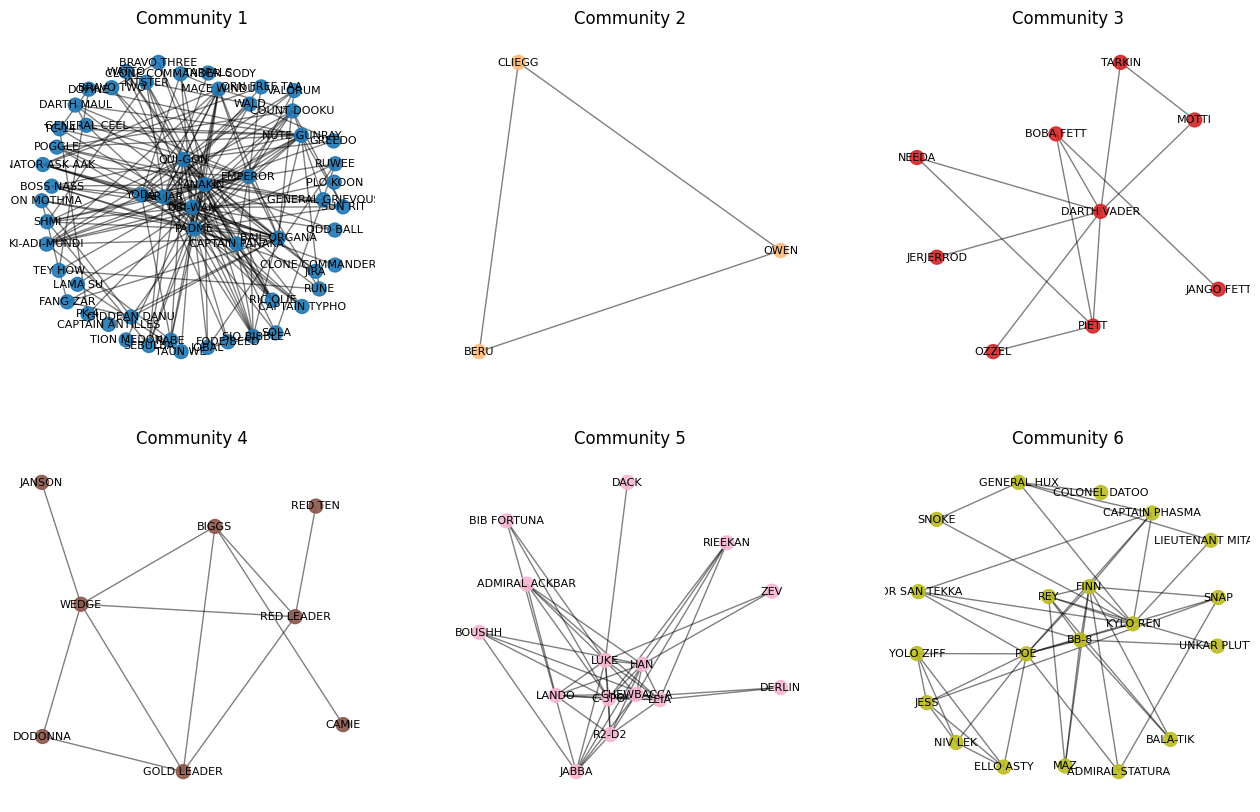

In [42]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
axes = axes.flatten()
for i, community in enumerate(louvain_communities_result):
    if i >= rows * cols:
        break
    subgraph = G.subgraph(community)
    pos_subgraph = nx.spring_layout(subgraph, seed=42, k= 3)
    ax = axes[i]
    nx.draw_networkx_nodes(subgraph, pos_subgraph, node_color=[distinct_colors[i]] * len(subgraph),
                           node_size=100, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(subgraph, pos_subgraph, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(subgraph, pos_subgraph, font_size=8, font_color='black', ax=ax)
    ax.set_title(f"Community {i + 1}", fontsize=12)
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')



# Mention Dataset

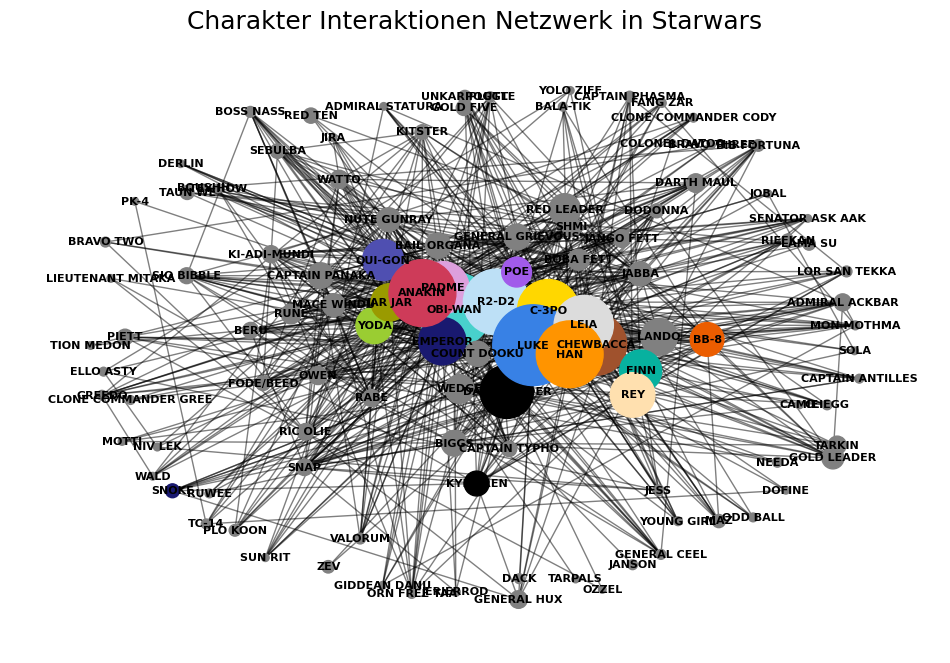

In [44]:
G = nx.Graph()

for node in mention_data['nodes']:
    G.add_node(node['name'], value=node['value'], color=node['colour'])

for link in mention_data['links']:
    source = mention_data['nodes'][link['source']]['name']
    target = mention_data['nodes'][link['target']]['name']
    G.add_edge(source, target, weight=link['value'])

pos = nx.spring_layout(G, seed=42, k=2)
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_sizes = [G.nodes[node]['value'] * 10 for node in G.nodes] #Skalierung mal 10

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_weight='bold')
plt.title("Charakter Interaktionen Netzwerk in Starwars", fontsize=18)
plt.axis('off')
plt.show()


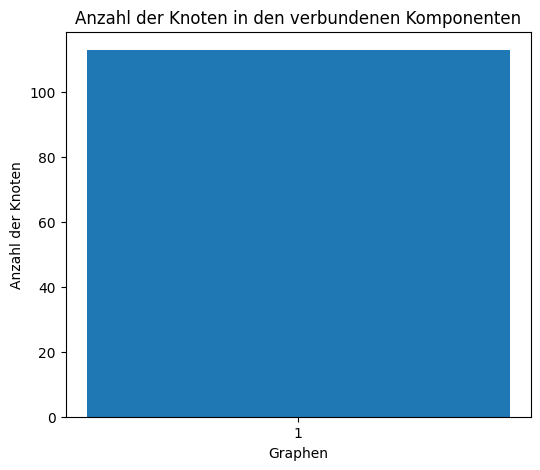

In [45]:
connected_components = list(nx.connected_components(G))
num_components = len(connected_components)
component_sizes = [len(component) for component in connected_components]

plt.figure(figsize=(6, 5))
plt.bar(range(1, num_components + 1), component_sizes)
plt.xlabel("Graphen")
plt.ylabel("Anzahl der Knoten")
plt.title("Anzahl der Knoten in den verbundenen Komponenten")
plt.xticks(range(1, num_components + 1))
plt.show()

In [ ]:
label_propagation_communities_result = list(nx.algorithms.community.label_propagation_communities(G))
num_label_propagation_communities = len(label_propagation_communities_result)
distinct_colors_lp = [plt.cm.tab20(i / num_label_propagation_communities) for i in range(num_label_propagation_communities)]

label_propagation_color_map = {}
for i, community in enumerate(label_propagation_communities_result):
    for node in community:
        label_propagation_color_map[node] = distinct_colors_lp[i]

node_colors_label_propagation = [label_propagation_color_map[node] for node in G.nodes]

plt.figure(figsize=(15, 15))
pos_label_propagation = nx.spring_layout(G, seed=42, k=3)
nx.draw_networkx_nodes(G, pos_label_propagation, node_color=node_colors_label_propagation, node_size=100, alpha=0.9)
nx.draw_networkx_edges(G, pos_label_propagation, alpha=0.5)
nx.draw_networkx_labels(G, pos_label_propagation, font_size=8, font_color='black')
plt.title("Clusters nach Labelpropagation", fontsize=18)
plt.axis('off')
plt.show()
